In [4]:
'''
IMPORTS
'''

# Torch
import torch
import torch.optim as optim
from torcheval.metrics import *
import torch.nn.functional as F

# Benny pointnet
from pointnet2_benny import pointnet2_cls_msg
from pointnet2_benny import provider
import cnn3d_xmuyzz.ResNetV2

# Custom modules
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.subject_dataset import *
from ozzy_torch_utils.plot import *
from ozzy_torch_utils.train_nn import *
from ozzy_torch_utils.model_parameters import *
from ozzy_torch_utils.init_dataloaders import *

import torch
from torcheval.metrics import *
from torch.utils.data import DataLoader
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import roc_curve, roc_auc_score
from ozzy_torch_utils.model_parameters import *


In [5]:
model_parameters = ModelParameters()

model_parameters.data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

# Disease labels from study
model_parameters.selected_labels = ['CN', 'MCI']

# Dictionary key representing the data of interest
model_parameters.data_string = 'lhcampus_pointcloud_aligned'

# Dictionary key representing the disease labels
model_parameters.labels_string = 'research_group'

# Lower batch size seemed to give better results
model_parameters.batch_size = 10

# Can drop last batch of the dataset as it will be smaller than the rest
model_parameters.drop_last = False

model_parameters.test_size = 0.2

model_parameters.num_epochs = 180

model_parameters.learning_rate = 0.005

model_parameters.model = pointnet2_cls_msg.get_model(len(model_parameters.selected_labels), normal_channel=False)

model_parameters.optimiser = optim.Adam(
                                model_parameters.model.parameters(),
                                lr=model_parameters.learning_rate,
                                betas=(0.9, 0.999),
                                eps=1e-08,
                                weight_decay=1e-4,
                                amsgrad=True
                            )

model_parameters.scheduler = torch.optim.lr_scheduler.LinearLR(model_parameters.optimiser, start_factor=1.0, end_factor=0.01, total_iters=50)

'''
Prediction configuration
'''
def run_prediction(inputs, labels):
    
    inputs = inputs.cpu().data.numpy()
    inputs = provider.random_point_dropout(inputs)
    inputs[:, :, 0:3] = provider.shift_point_cloud(inputs[:, :, 0:3])
    inputs = torch.Tensor(inputs).cuda()
    inputs = inputs.transpose(2, 1)
    
    logit_output, *_ = model_parameters.model(inputs)
    
    loss = model_parameters.criterion(logit_output, labels)
    
    # Apply exponent as the output of the model is log softmax
    pred_probability = F.softmax(logit_output, dim=1)
        
    pred_labels = torch.argmax(pred_probability, dim=1)
    
    return loss, pred_probability, pred_labels

model_parameters.run_prediction = run_prediction

dataset = SubjectDataset(model_parameters.data_path, model_parameters.selected_labels, load_in_memory = True, data_string=model_parameters.data_string, labels_string=model_parameters.labels_string)

dataloader = DataLoader(dataset, batch_size=model_parameters.batch_size, shuffle=True, num_workers = 4, drop_last=model_parameters.drop_last)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

# Set the criterion after getting the weights
model_parameters.criterion = torch.nn.CrossEntropyLoss(weight=(get_weights(dataloader)).to(device))


Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']
Loading dataset into memory



100%|██████████| 543/543 [00:00<00:00, 965.20it/s]


In [6]:

training_losses, model = train_nn(model_parameters, dataloader, None, device, train_only=True, scheduler_start=50)


Using cuda device
------------------------


Starting epoch 1


Training:


100%|██████████| 55/55 [00:09<00:00,  5.72it/s]

------------------------


Starting epoch 2


Training:



100%|██████████| 55/55 [00:09<00:00,  6.06it/s]

------------------------


Starting epoch 3


Training:



100%|██████████| 55/55 [00:08<00:00,  6.38it/s]

------------------------


Starting epoch 4


Training:



100%|██████████| 55/55 [00:08<00:00,  6.23it/s]

------------------------


Starting epoch 5


Training:



100%|██████████| 55/55 [00:09<00:00,  5.81it/s]

------------------------


Starting epoch 6


Training:



100%|██████████| 55/55 [00:09<00:00,  5.69it/s]

------------------------


Starting epoch 7


Training:



100%|██████████| 55/55 [00:09<00:00,  5.72it/s]

------------------------


Starting epoch 8


Training:



100%|██████████| 55/55 [00:09<00:00,  5.76it/s]

------------------------


Starting epoch 9


Training:



100%|██████████| 55/55 [00:09<00:00,  5.78it/s]

------------------------


Starting epoch 10


Training:



100%|██████████| 55/55 [00:09<00:00,  5.78it/s]

------------------------


Starting epoch 11


Training:



100%|██████████| 55/55 [00:09<00:00,  5.78it/s]

------------------------


Starting epoch 12


Training:



100%|██████████| 55/55 [00:09<00:00,  5.80it/s]

------------------------


Starting epoch 13


Training:



100%|██████████| 55/55 [00:09<00:00,  5.82it/s]

------------------------


Starting epoch 14


Training:



100%|██████████| 55/55 [00:09<00:00,  5.94it/s]

------------------------


Starting epoch 15


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 16


Training:



100%|██████████| 55/55 [00:09<00:00,  6.03it/s]

------------------------


Starting epoch 17


Training:



100%|██████████| 55/55 [00:09<00:00,  5.99it/s]

------------------------


Starting epoch 18


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 19


Training:



100%|██████████| 55/55 [00:09<00:00,  6.03it/s]

------------------------


Starting epoch 20


Training:



100%|██████████| 55/55 [00:08<00:00,  6.14it/s]

------------------------


Starting epoch 21


Training:



100%|██████████| 55/55 [00:08<00:00,  6.14it/s]

------------------------


Starting epoch 22


Training:



100%|██████████| 55/55 [00:08<00:00,  6.15it/s]

------------------------


Starting epoch 23


Training:



100%|██████████| 55/55 [00:08<00:00,  6.15it/s]

------------------------


Starting epoch 24


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 25


Training:



100%|██████████| 55/55 [00:08<00:00,  6.14it/s]

------------------------


Starting epoch 26


Training:



100%|██████████| 55/55 [00:09<00:00,  6.11it/s]

------------------------


Starting epoch 27


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 28


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 29


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 30


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 31


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 32


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 33


Training:



100%|██████████| 55/55 [00:08<00:00,  6.16it/s]

------------------------


Starting epoch 34


Training:



100%|██████████| 55/55 [00:08<00:00,  6.13it/s]

------------------------


Starting epoch 35


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 36


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 37


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 38


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 39


Training:



100%|██████████| 55/55 [00:08<00:00,  6.11it/s]

------------------------


Starting epoch 40


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 41


Training:



100%|██████████| 55/55 [00:09<00:00,  6.11it/s]

------------------------


Starting epoch 42


Training:



100%|██████████| 55/55 [00:09<00:00,  6.11it/s]

------------------------


Starting epoch 43


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 44


Training:



100%|██████████| 55/55 [00:08<00:00,  6.13it/s]

------------------------


Starting epoch 45


Training:



100%|██████████| 55/55 [00:08<00:00,  6.13it/s]

------------------------


Starting epoch 46


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 47


Training:



100%|██████████| 55/55 [00:09<00:00,  6.11it/s]

------------------------


Starting epoch 48


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 49


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 50


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 51


Training:



100%|██████████| 55/55 [00:09<00:00,  5.72it/s]

------------------------


Starting epoch 52


Training:



100%|██████████| 55/55 [00:09<00:00,  5.80it/s]

------------------------


Starting epoch 53


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 54


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 55


Training:



100%|██████████| 55/55 [00:08<00:00,  6.13it/s]

------------------------


Starting epoch 56


Training:



100%|██████████| 55/55 [00:08<00:00,  6.14it/s]

------------------------


Starting epoch 57


Training:



100%|██████████| 55/55 [00:08<00:00,  6.13it/s]

------------------------


Starting epoch 58


Training:



100%|██████████| 55/55 [00:08<00:00,  6.13it/s]

------------------------


Starting epoch 59


Training:



100%|██████████| 55/55 [00:08<00:00,  6.14it/s]

------------------------


Starting epoch 60


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 61


Training:



100%|██████████| 55/55 [00:09<00:00,  6.07it/s]

------------------------


Starting epoch 62


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 63


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 64


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 65


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 66


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 67


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 68


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 69


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 70


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 71


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 72


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 73


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 74


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 75


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 76


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 77


Training:



100%|██████████| 55/55 [00:09<00:00,  6.07it/s]

------------------------


Starting epoch 78


Training:



100%|██████████| 55/55 [00:09<00:00,  5.91it/s]

------------------------


Starting epoch 79


Training:



100%|██████████| 55/55 [00:09<00:00,  5.81it/s]

------------------------


Starting epoch 80


Training:



100%|██████████| 55/55 [00:09<00:00,  6.06it/s]

------------------------


Starting epoch 81


Training:



100%|██████████| 55/55 [00:09<00:00,  6.06it/s]

------------------------


Starting epoch 82


Training:



100%|██████████| 55/55 [00:09<00:00,  6.04it/s]

------------------------


Starting epoch 83


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 84


Training:



100%|██████████| 55/55 [00:09<00:00,  6.11it/s]

------------------------


Starting epoch 85


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 86


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 87


Training:



100%|██████████| 55/55 [00:08<00:00,  6.11it/s]

------------------------


Starting epoch 88


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 89


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 90


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 91


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 92


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 93


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 94


Training:



100%|██████████| 55/55 [00:08<00:00,  6.11it/s]

------------------------


Starting epoch 95


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 96


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 97


Training:



100%|██████████| 55/55 [00:09<00:00,  6.06it/s]

------------------------


Starting epoch 98


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 99


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 100


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 101


Training:



100%|██████████| 55/55 [00:09<00:00,  6.11it/s]

------------------------


Starting epoch 102


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 103


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 104


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 105


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 106


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 107


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 108


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 109


Training:



100%|██████████| 55/55 [00:09<00:00,  6.07it/s]

------------------------


Starting epoch 110


Training:



100%|██████████| 55/55 [00:09<00:00,  6.07it/s]

------------------------


Starting epoch 111


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 112


Training:



100%|██████████| 55/55 [00:09<00:00,  6.05it/s]

------------------------


Starting epoch 113


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 114


Training:



100%|██████████| 55/55 [00:09<00:00,  6.10it/s]

------------------------


Starting epoch 115


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 116


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 117


Training:



100%|██████████| 55/55 [00:09<00:00,  6.09it/s]

------------------------


Starting epoch 118


Training:



100%|██████████| 55/55 [00:09<00:00,  6.07it/s]

------------------------


Starting epoch 119


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 120


Training:



100%|██████████| 55/55 [00:09<00:00,  6.07it/s]

------------------------


Starting epoch 121


Training:



100%|██████████| 55/55 [00:09<00:00,  5.93it/s]

------------------------


Starting epoch 122


Training:



100%|██████████| 55/55 [00:09<00:00,  5.77it/s]

------------------------


Starting epoch 123


Training:



100%|██████████| 55/55 [00:09<00:00,  6.01it/s]

------------------------


Starting epoch 124


Training:



100%|██████████| 55/55 [00:09<00:00,  6.05it/s]

------------------------


Starting epoch 125


Training:



100%|██████████| 55/55 [00:09<00:00,  6.02it/s]

------------------------


Starting epoch 126


Training:



100%|██████████| 55/55 [00:09<00:00,  5.99it/s]

------------------------


Starting epoch 127


Training:



100%|██████████| 55/55 [00:09<00:00,  6.03it/s]

------------------------


Starting epoch 128


Training:



100%|██████████| 55/55 [00:09<00:00,  6.03it/s]

------------------------


Starting epoch 129


Training:



100%|██████████| 55/55 [00:09<00:00,  6.05it/s]

------------------------


Starting epoch 130


Training:



100%|██████████| 55/55 [00:08<00:00,  6.12it/s]

------------------------


Starting epoch 131


Training:



100%|██████████| 55/55 [00:09<00:00,  6.03it/s]

------------------------


Starting epoch 132


Training:



100%|██████████| 55/55 [00:09<00:00,  6.05it/s]

------------------------


Starting epoch 133


Training:



100%|██████████| 55/55 [00:09<00:00,  6.02it/s]

------------------------


Starting epoch 134


Training:



100%|██████████| 55/55 [00:08<00:00,  6.14it/s]

------------------------


Starting epoch 135


Training:



100%|██████████| 55/55 [00:09<00:00,  6.05it/s]

------------------------


Starting epoch 136


Training:



100%|██████████| 55/55 [00:09<00:00,  6.06it/s]

------------------------


Starting epoch 137


Training:



100%|██████████| 55/55 [00:09<00:00,  6.04it/s]

------------------------


Starting epoch 138


Training:



100%|██████████| 55/55 [00:09<00:00,  6.02it/s]

------------------------


Starting epoch 139


Training:



100%|██████████| 55/55 [00:09<00:00,  6.04it/s]

------------------------


Starting epoch 140


Training:



100%|██████████| 55/55 [00:09<00:00,  6.05it/s]

------------------------


Starting epoch 141


Training:



100%|██████████| 55/55 [00:09<00:00,  6.04it/s]

------------------------


Starting epoch 142


Training:



100%|██████████| 55/55 [00:09<00:00,  6.05it/s]

------------------------


Starting epoch 143


Training:



100%|██████████| 55/55 [00:09<00:00,  6.05it/s]

------------------------


Starting epoch 144


Training:



100%|██████████| 55/55 [00:09<00:00,  6.08it/s]

------------------------


Starting epoch 145


Training:



100%|██████████| 55/55 [00:09<00:00,  6.06it/s]

------------------------


Starting epoch 146


Training:



100%|██████████| 55/55 [00:09<00:00,  6.03it/s]

------------------------


Starting epoch 147


Training:



100%|██████████| 55/55 [00:09<00:00,  6.06it/s]

------------------------


Starting epoch 148


Training:



100%|██████████| 55/55 [00:09<00:00,  5.81it/s]

------------------------


Starting epoch 149


Training:



100%|██████████| 55/55 [00:09<00:00,  5.73it/s]

------------------------


Starting epoch 150


Training:



100%|██████████| 55/55 [00:08<00:00,  6.41it/s]

------------------------


Starting epoch 151


Training:



100%|██████████| 55/55 [00:08<00:00,  6.29it/s]

------------------------


Starting epoch 152


Training:



100%|██████████| 55/55 [00:08<00:00,  6.27it/s]

------------------------


Starting epoch 153


Training:



100%|██████████| 55/55 [00:08<00:00,  6.53it/s]

------------------------


Starting epoch 154


Training:



100%|██████████| 55/55 [00:08<00:00,  6.57it/s]

------------------------


Starting epoch 155


Training:



100%|██████████| 55/55 [00:08<00:00,  6.57it/s]

------------------------


Starting epoch 156


Training:



100%|██████████| 55/55 [00:08<00:00,  6.57it/s]

------------------------


Starting epoch 157


Training:



100%|██████████| 55/55 [00:08<00:00,  6.57it/s]

------------------------


Starting epoch 158


Training:



100%|██████████| 55/55 [00:08<00:00,  6.59it/s]

------------------------


Starting epoch 159


Training:



100%|██████████| 55/55 [00:08<00:00,  6.58it/s]

------------------------


Starting epoch 160


Training:



100%|██████████| 55/55 [00:08<00:00,  6.54it/s]

------------------------


Starting epoch 161


Training:



100%|██████████| 55/55 [00:08<00:00,  6.59it/s]

------------------------


Starting epoch 162


Training:



100%|██████████| 55/55 [00:08<00:00,  6.54it/s]

------------------------


Starting epoch 163


Training:



100%|██████████| 55/55 [00:08<00:00,  6.61it/s]

------------------------


Starting epoch 164


Training:



100%|██████████| 55/55 [00:08<00:00,  6.58it/s]

------------------------


Starting epoch 165


Training:



100%|██████████| 55/55 [00:08<00:00,  6.59it/s]

------------------------


Starting epoch 166


Training:



100%|██████████| 55/55 [00:08<00:00,  6.58it/s]

------------------------


Starting epoch 167


Training:



100%|██████████| 55/55 [00:08<00:00,  6.57it/s]

------------------------


Starting epoch 168


Training:



100%|██████████| 55/55 [00:08<00:00,  6.58it/s]

------------------------


Starting epoch 169


Training:



100%|██████████| 55/55 [00:08<00:00,  6.57it/s]

------------------------


Starting epoch 170


Training:



100%|██████████| 55/55 [00:08<00:00,  6.60it/s]

------------------------


Starting epoch 171


Training:



100%|██████████| 55/55 [00:08<00:00,  6.55it/s]

------------------------


Starting epoch 172


Training:



100%|██████████| 55/55 [00:08<00:00,  6.60it/s]

------------------------


Starting epoch 173


Training:



100%|██████████| 55/55 [00:08<00:00,  6.47it/s]

------------------------


Starting epoch 174


Training:



100%|██████████| 55/55 [00:08<00:00,  6.40it/s]

------------------------


Starting epoch 175


Training:



100%|██████████| 55/55 [00:08<00:00,  6.21it/s]

------------------------


Starting epoch 176


Training:



100%|██████████| 55/55 [00:09<00:00,  6.03it/s]

------------------------


Starting epoch 177


Training:



100%|██████████| 55/55 [00:08<00:00,  6.33it/s]

------------------------


Starting epoch 178


Training:



100%|██████████| 55/55 [00:08<00:00,  6.28it/s]

------------------------


Starting epoch 179


Training:



100%|██████████| 55/55 [00:08<00:00,  6.17it/s]

------------------------


Starting epoch 180


Training:



100%|██████████| 55/55 [00:08<00:00,  6.23it/s]


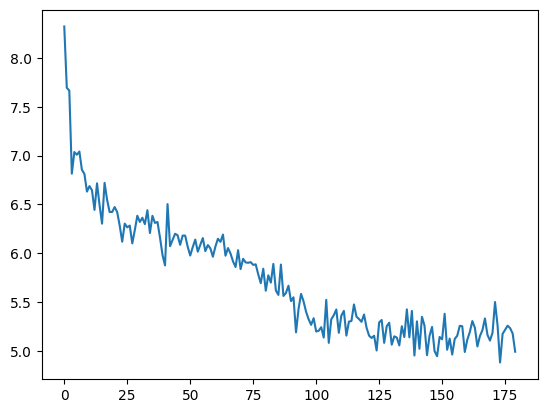

In [7]:
plt.plot(training_losses)
plt.show()

In [11]:
model.eval()

model.to('cpu')

torch.save(model.state_dict(), 'pointnet.pth')